In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, ResidualDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
import numpy as np
from scipy.special import comb

%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\doeltz\development\RiVaPy\notebooks\models\../..\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


# Single WindPowerForecast Model

In [4]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forward_expiries = [timegrid[-10] +i/(365.0*24.0) for i in range(4)]#
#forward_expiries = [timegrid[-1] + i for i in range(4)]
n_sims = 10_000
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.001, volatility=3.30)
rnd = np.random.normal(size=wind_onshore.rnd_shape(n_sims, timegrid.shape[0]))
results = wind_onshore.simulate(timegrid, rnd, 
                                       expiries=forward_expiries, 
                                       initial_forecasts=[0.8, 0.7,0.6,0.5])


In [11]:
results.keys()

{'Offshore:0',
 'Offshore:1',
 'Offshore:2',
 'Offshore:3',
 'Onshore:0',
 'Onshore:1',
 'Onshore:2',
 'Onshore:3',
 'Wind_Germany:0',
 'Wind_Germany:1',
 'Wind_Germany:2',
 'Wind_Germany:3'}

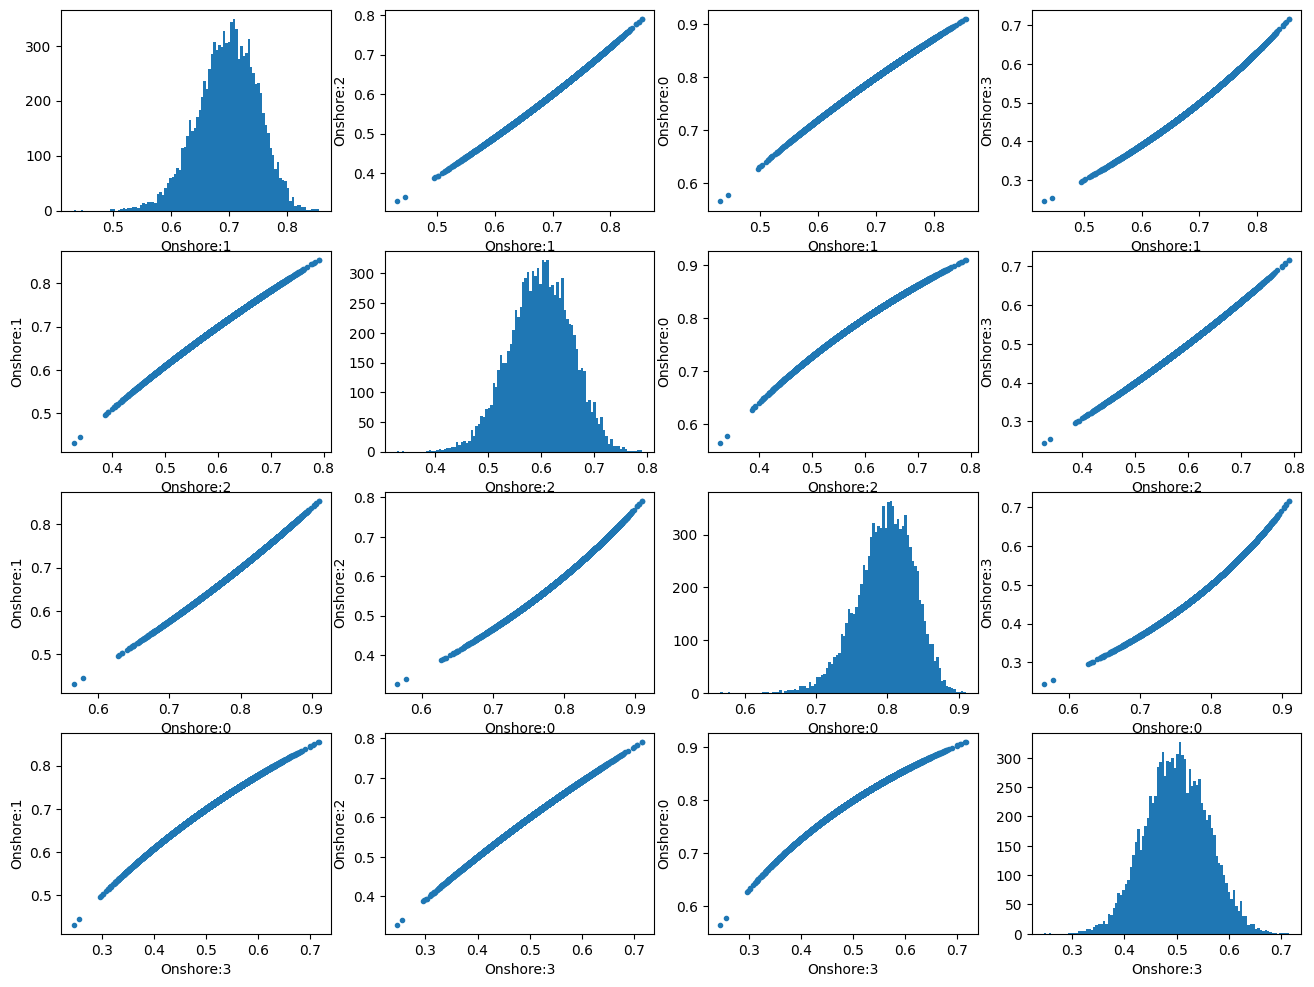

In [5]:
timepoint = -1
plt.figure(figsize=(16,12))
i=1
for k in results.keys():
    f1 = results.get(k)
    for l in results.keys():
        plt.subplot(4,4,i)
        f2 = results.get(l)
        if k==l:
            plt.hist(f1[timepoint], bins=100, label=k)
            plt.xlabel(k)
        else:
            plt.plot(f1[timepoint], f2[timepoint], '.')
            plt.xlabel(k)
            plt.ylabel(l)
        i += 1


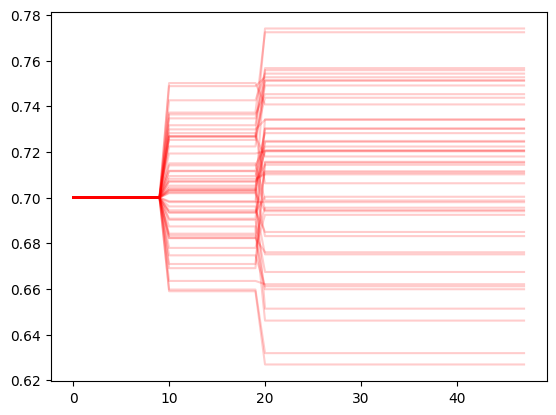

In [6]:
for k in results.keys():
    tmp = results.get(k, forecast_timepoints=[10, 20])
    for i in range(50):
        plt.plot(tmp[:,i], '-r', alpha=0.2)
    break

# Multiregion Windpower Model

In [7]:
#wind = wind_forecast_model.simulate(timegrid, rnd)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.001, volatility=3.30)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.7,0.3]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=500.0,
                                    rnd_weights=[0.3,0.7]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

In [8]:
rnd = np.random.normal(size=wind.rnd_shape(n_sims, timegrid.shape[0]))
results = wind.simulate(timegrid, rnd, expiries=forward_expiries, 
                                       initial_forecasts={'Onshore': [0.8, 0.7,0.6,0.5],
                                                          'Offshore': [0.6,0.6,0.6,0.6]}
                               )

In [12]:
results.keys()

{'Offshore:0',
 'Offshore:1',
 'Offshore:2',
 'Offshore:3',
 'Onshore:0',
 'Onshore:1',
 'Onshore:2',
 'Onshore:3',
 'Wind_Germany:0',
 'Wind_Germany:1',
 'Wind_Germany:2',
 'Wind_Germany:3'}

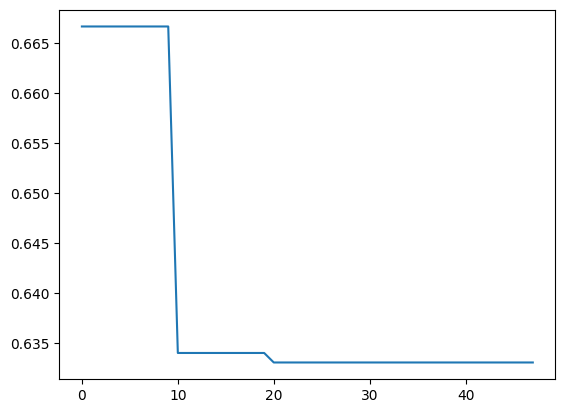

In [9]:
tmp = results.get('Wind_Germany:1', forecast_timepoints=[10, 20])
plt.plot(tmp[:,0]);

# Residual Demand Forward Model